In [1]:
cd dataset

C:\Users\Miya\Desktop\cna\dataset


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('repositories_refined.csv',parse_dates=['Month, Day, Year of Date'])
#data = data[data['Coding Effort']!=0]
data.columns= ['Worker ID','Repository ID','Coding Effort','Month, Day, Year of Date']

In [140]:
X_test = data[data['Month, Day, Year of Date']>='2015-09-21']
X_train = data[data['Month, Day, Year of Date']<'2015-09-21']

In [141]:
print(X_train.shape)
print(X_test.shape)

(151689, 4)
(20665, 4)


In [142]:
deve_nodes_train = list(set(X_train.values[:,0]))
deve_nodes_test = list(set(X_test.values[:,0]))

In [143]:
X_test = X_test[X_test['Worker ID'].isin([test for test in deve_nodes_test if test in deve_nodes_train])]

In [144]:
X_test = X_test.groupby(['Worker ID','Repository ID']).sum().reset_index()

In [145]:
X_train = X_train.groupby(['Worker ID','Repository ID']).sum().reset_index().values

In [357]:
from sklearn import preprocessing
preprocessing.scale(X_train[:,2], axis=0, with_mean=True, with_std=False, copy=True)

array([ -55.49015581,  -55.49015581,   14.55984419, ...,  -15.48015581,
        234.81984419,    5.19984419])

In [146]:
X_test.shape[0]/X_train.shape[0]

0.5647039527636543

In [160]:
actual_list = []
to_predict_deve = set(X_test['Worker ID'])
for dev in to_predict_deve:
    repo = X_test[X_test['Worker ID']==dev]['Repository ID'].values
    actual_list.append(list(repo))

In [379]:
import networkx as nx
%matplotlib inline
from networkx.algorithms import bipartite
G_train = nx.Graph()
for i,v,j in zip(X_train[:,0],X_train[:,1],X_train[:,2]):
    G_train.add_edge(i,v,weight = j)

In [383]:
nx.write_gml(G_train,'g_2.gml')

In [120]:
deve_nodes = list(set(X_train[:,0]))

def normalize(x):
    if x==0:
        x = 1
    else:
        x
    return x

def my_weight(G_train, u, v, weight='weight'):
    w = 0
    for nbr in set(G_train[u]) & set(G_train[v]):
        u_sum = normalize(sum(list(map(lambda x:x['weight'],G_train[u].values()))))
        v_sum = normalize(sum(list(map(lambda x:x['weight'],G_train[v].values()))))
        nbr_sum = normalize(sum(list(map(lambda x:x['weight'],G_train[nbr].values()))))
        
        w += (G_train.edge[u][nbr].get(weight,1)/u_sum) * (G_train.edge[v][nbr].get(weight,1)/nbr_sum)
        return w 
    
    
def jaccard(G, u, v):
    unbrs = set(G[u])
    vnbrs = set(G[v])
    return float(len(unbrs & vnbrs)) / len(unbrs)
    
    
    
bipartite.generic_weighted_projected_graph(G_train, ['aah'], weight_function=my_weight).edges(data=True)

[('aah', 'aic', {'weight': 0.0}), ('aah', 'eyz', {'weight': 0.0})]

In [401]:
pd.read_csv('assign.csv').set_index('nodes').head()

,ml_member,info_member,wt_member,fg_member,lp_member,kmeans
nodes,,,,,,
aaa,1,833,215,294,1,31
aah,2,455,213,295,2,31
aaj,359,172,165,63,3,30
aaq,43,1,215,49,4,29
aau,221,2,215,14,5,27


In [398]:
import itertools
def neighbors_cluster(node):
    
    refer = pd.read_csv('assign.csv').set_index('nodes')    
    ml = refer.ix[node,0]
    info = refer.ix[node,1]
    wt = refer.ix[node,2]
    fg = refer.ix[node,3]
    lp = refer.ix[node,4]
    kmeans = refer.ix[node,5]
    
    ml_nn = refer[refer['ml_member']==ml].index
    wt_nn = refer[refer['wt_member']==wt].index
    info_nn = refer[refer['info_member']==info].index
    fg_nn = refer[refer['fg_member']==fg].index
    lp_nn = refer[refer['lp_member']==lp].index
    kmeans_nn = refer[refer['kmeans']==kmeans].index
    
    cluster_nn = list(itertools.chain(wt_nn,kmeans_nn,lp_nn,fg_nn)) #ml_nn,info_nn
    
    return cluster_nn

In [412]:
def neighbors_cluster_weighted(node):
    
    refer = pd.read_csv('assign.csv').set_index('nodes')
    
    ml = refer.ix[node,0]
    info = refer.ix[node,1]
    wt = refer.ix[node,2]
    fg = refer.ix[node,3]
    lp = refer.ix[node,4]
    kmeans = refer.ix[node,5]
    
    ml_nn = refer[refer['ml_member']==ml].index
    wt_nn = refer[refer['wt_member']==wt].index
    info_nn = refer[refer['info_member']==info].index
    fg_nn = refer[refer['fg_member']==fg].index
    lp_nn = refer[refer['lp_member']==lp].index
    kmeans_nn = refer[refer['kmeans']==kmeans].index
    

    
    return wt_nn,kmeans_nn,ml_nn,info_nn,fg_nn,lp_nn

In [413]:
K = 6
def limit_k(rs_list, k = K):
    if len(rs_list)<k:
        return rs_list
    else:
        return rs_list[:k]  

In [414]:
def ensemble_similarity(node,wf):
    nns = bipartite.generic_weighted_projected_graph(G_train, [node], weight_function= wf).edges(data=True)
    cluster_nn = neighbors_cluster(node)
    
    dict_rs = dict()
    
    for nn_sug in nns:
        nn = nn_sug[1]
        we = nn_sug[2]['weight']
        
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*np.exp(we)

        
    for nn in cluster_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*1
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [415]:
def community_weight():
    df = pd.read_csv('assign.csv').set_index('nodes')
    wt_w = len(df['wt_member'].unique())/100
    ml_w = len(df['ml_member'].unique())/100
    info_w = len(df['info_member'].unique())/100
    fg_w = len(df['fg_member'].unique())/100
    lp_w = len(df['lp_member'].unique())/100
    
    return wt_w,ml_w,info_w,fg_w,lp_w

In [416]:
def ensemble_similarity_weighted(node,wf):
    
    nns = bipartite.generic_weighted_projected_graph(G_train, [node], weight_function= wf).edges(data=True)
    
    wt_nn,kmeans_nn,ml_nn,info_nn,fg_nn,lp_nn = neighbors_cluster_weighted(node)
    
    wt_w,ml_w,info_w,fg_w,lp_w = community_weight()
     
    dict_rs = dict()
    
    for nn_sug in nns:
        nn = nn_sug[1]
        we = nn_sug[2]['weight']
        
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*np.exp(we)

        
    for nn in wt_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*wt_w

    for nn in ml_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*ml_w

    for nn in info_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*info_w
            
    for nn in kmeans_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*30/100
            
    for nn in fg_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*fg_w
            
    for nn in lp_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*lp_w
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [417]:
def projection_similarity(node,wf):
    nns = bipartite.generic_weighted_projected_graph(G_train, [node], weight_function= wf).edges(data=True)
    cluster_nn = neighbors_cluster(node)
    
    dict_rs = dict()
    
    for nn_sug in nns:
        nn = nn_sug[1]
        we = nn_sug[2]['weight']
        
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*np.exp(we)
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [418]:
def cluster_similarity(node):
    
    dict_rs = dict()
    cluster_nn = neighbors_cluster(node)

    for nn in cluster_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [419]:
def cluster_similarity_weighted(node):
    
    dict_rs = dict()
    
    wt_nn,kmeans_nn,ml_nn,info_nn,fg_nn,lp_nn = neighbors_cluster_weighted(node)
    
    wt_w,ml_w,info_w,fg_w,lp_w = community_weight()

    for nn in wt_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*wt_w

    for nn in ml_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*ml_w

    for nn in info_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*info_w
            
    for nn in kmeans_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*30/100
            
    for nn in fg_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*fg_w
            
    for nn in lp_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*lp_w
        
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [429]:
def similarity_rs(node_list, method = "projection_similarity",wf = my_weight):
    
    dict_rs = dict()
    for node in node_list:
        if method == 'projection_similarity':
             rs_list = projection_similarity(node,wf)
        if method == 'cluster_similarity':
             rs_list = cluster_similarity(node)
        if method == 'cluster_similarity_weighted':
             rs_list = cluster_similarity_weighted(node)
        if method == 'ensemble_similarity_weighted':
             rs_list = ensemble_similarity_weighted(node,wf)
        if method == 'ensemble_similarity':
             rs_list = ensemble_similarity(node,wf)
        if method == 'ensemble_similarity_weighted_half':
            rs_list1 = cluster_similarity_weighted(node)
            rs_list1 = limit_k(rs_list1, k = 2)
            rs_list2 = projection_similarity(node,wf)
            rs_list2 = limit_k(rs_list2, k = 4)
            rs_list = rs_list1 + rs_list2
            
    
        dict_rs[node] = rs_list
    
    return dict_rs

In [421]:
def apk(actual, predicted, k= K):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual_list, predicted_list, k= 20):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
            
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual_list, predicted_list)])

In [432]:
y_predict_dict_p = similarity_rs(to_predict_deve, method = "projection_similarity",wf = my_weight)

In [344]:
y_predict_dict_p_j = similarity_rs(to_predict_deve, method = "projection_similarity",wf = jaccard)

In [410]:
y_predict_dict_c = similarity_rs(to_predict_deve, method = "cluster_similarity",wf = my_weight)

In [423]:
y_predict_dict_cw = similarity_rs(to_predict_deve, method = "cluster_similarity_weighted",wf = my_weight)

In [368]:
y_predict_dict_e = similarity_rs(to_predict_deve, method = "ensemble_similarity",wf = my_weight)

In [369]:
y_predict_dict_e_w = similarity_rs(to_predict_deve, method = "ensemble_similarity_weighted",wf = my_weight)

In [430]:
y_predict_dict_e_w_h = similarity_rs(to_predict_deve, method = "ensemble_similarity_weighted_half",wf = my_weight)

In [433]:
mapk(actual_list, y_predict_dict_p.values(), k= 6)

0.7662398822663723

In [362]:
mapk(actual_list, y_predict_dict_p_j.values(), k= 6)

0.64562153544272749

In [422]:
mapk(actual_list, y_predict_dict_c.values(), k= 6)

0.38988839833210692

In [428]:
mapk(actual_list, y_predict_dict_cw.values(), k= 6)

0.65136460632818249

In [373]:
mapk(actual_list, y_predict_dict_e.values(), k= 6)

0.38067893058621532

In [374]:
mapk(actual_list, y_predict_dict_e_w.values(), k= 6)

0.52254819720382639

In [431]:
mapk(actual_list, y_predict_dict_e_w_h.values(), k= 6)

0.67428035320088298

In [384]:
wt = pd.read_csv('wt_df.csv')
wt.columns = ['wt_member','nodes']

ml = pd.read_csv('ml_df.csv')
ml.columns = ['ml_member','nodes']

info = pd.read_csv('info_df.csv')
info.columns = ['info_member','nodes']

fg = pd.read_csv('fg_df.csv')
fg.columns = ['fg_member','nodes']

lp = pd.read_csv('lp_df.csv')
lp.columns = ['lp_member','nodes']

In [209]:
len(wt['wt_member'].unique())

217

In [390]:
len(lp['lp_member'].unique())

591

In [ ]:
len(wt['fg_member'].unique())

In [211]:
len(ml['ml_member'].unique())

673

In [210]:
len(info['info_member'].unique())

839

In [170]:
len(ml)==len(info)==len(wt)

True

In [393]:
temp = pd.merge(ml,info, how='inner', on='nodes')
temp = pd.merge(temp,wt, how='inner', on='nodes')
temp = pd.merge(temp,fg, how='inner', on='nodes')
temp = pd.merge(temp,lp, how='inner', on='nodes')

In [172]:
degree_df = pd.DataFrame.from_dict({'nodes':list(nx.degree(G_train).keys()),'Degree':list(nx.degree(G_train).values())})
betweenness_df = pd.DataFrame({'between':list(nx.betweenness_centrality(G_train).values())})
close_df = pd.DataFrame({'close':list(nx.closeness_centrality(G_train).values())})
eigen_df = pd.DataFrame({'eigen':list(nx.eigenvector_centrality_numpy(G_train).values())})

temp2 = pd.concat([degree_df,betweenness_df,close_df,eigen_df],axis = 1,join = 'inner')
temp2 = temp2[temp2['nodes'].isin(deve_nodes)].set_index('nodes')

In [173]:
len(temp2)

2585

In [177]:
#X_kmeans = np.exp(temp2.values)
X_kmeans = temp2.values

In [178]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

K = range(1,50)
distortions = []
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_kmeans)
    kmeanModel.fit(X_kmeans)
    distortions.append(sum(np.min(cdist(X_kmeans, kmeanModel.cluster_centers_, 'cosine'), axis=1)) / X_kmeans.shape[0])

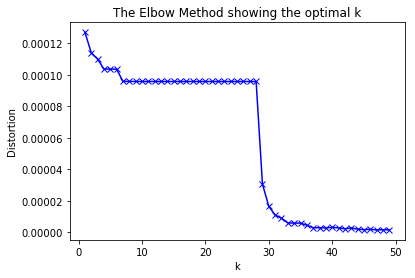

In [179]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
plt.savefig('elbow.png')

In [229]:
kmeans = KMeans(n_clusters= 40).fit(X_kmeans)
kmeans_assign = kmeans.labels_

In [230]:
kmeans_df = pd.DataFrame(np.asarray([temp2.index, kmeans_assign]).T,columns = ['nodes','kmeans'])

In [394]:
assign_all = pd.merge(temp,kmeans_df, how='inner', on='nodes').set_index('nodes')
assign_all.to_csv('assign.csv')

In [396]:
assign_all.head()

,ml_member,info_member,wt_member,fg_member,lp_member,kmeans
nodes,,,,,,
aaa,1,833,215,294,1,31
aah,2,455,213,295,2,31
aaj,359,172,165,63,3,30
aaq,43,1,215,49,4,29
aau,221,2,215,14,5,27
